In [19]:
# -*- coding: utf-8 -*-
#
# ベイズ推定による回帰分析
#
# 2015/06/23 ver1.0
# 2019/09/10 ver1.1 Python2->3に関するFuture Warningに対処主に描画関係に対処
#

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal, multivariate_normal

beta = 1.0/(0.3)**2     # 真の分布の分散
alpha = 1.0/100**2      # 事前分布の分散
order = 9               # 多項式の字数

# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2.0*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

# 事後分布に基づく推定曲線、および、事後分布の平均と分散を計算
def resolve(dataset, m):
    t = dataset.y
    phis = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phis = pd.concat([phis,p], axis=1)

    for index, line in phis.iterrows():
        phi = DataFrame(line)
        if index == 0:
            phiphi = np.dot(phi,phi.T)
        else:
            phiphi += np.dot(phi,phi.T)
    s_inv = alpha * DataFrame(np.identity(m+1)) + beta * phiphi
    s = np.linalg.inv(s_inv) # 事後分布の共分散行列

    # 平均 m(x)
    def mean_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        for index, line in phis.iterrows():
            if index == 0:
                tmp = t[index] * line
            else:
                tmp += t[index] * line
        return (beta * np.dot(np.dot(phi_x0.T, s), DataFrame(tmp))).flatten()

    # 標準偏差 s(x)
    def deviation_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        deviation = np.sqrt(1.0/beta + np.dot(np.dot(phi_x0.T, s), phi_x0))
        return deviation.diagonal()

    for index, line in phis.iterrows():
        if index == 0:
            tmp = t[index] * line
        else:
            tmp += t[index] * line
    mean = beta * np.dot(s, DataFrame(tmp)).flatten() # 事後分布の平均

    return mean_fun, deviation_fun, mean, s

/Users/saita/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt


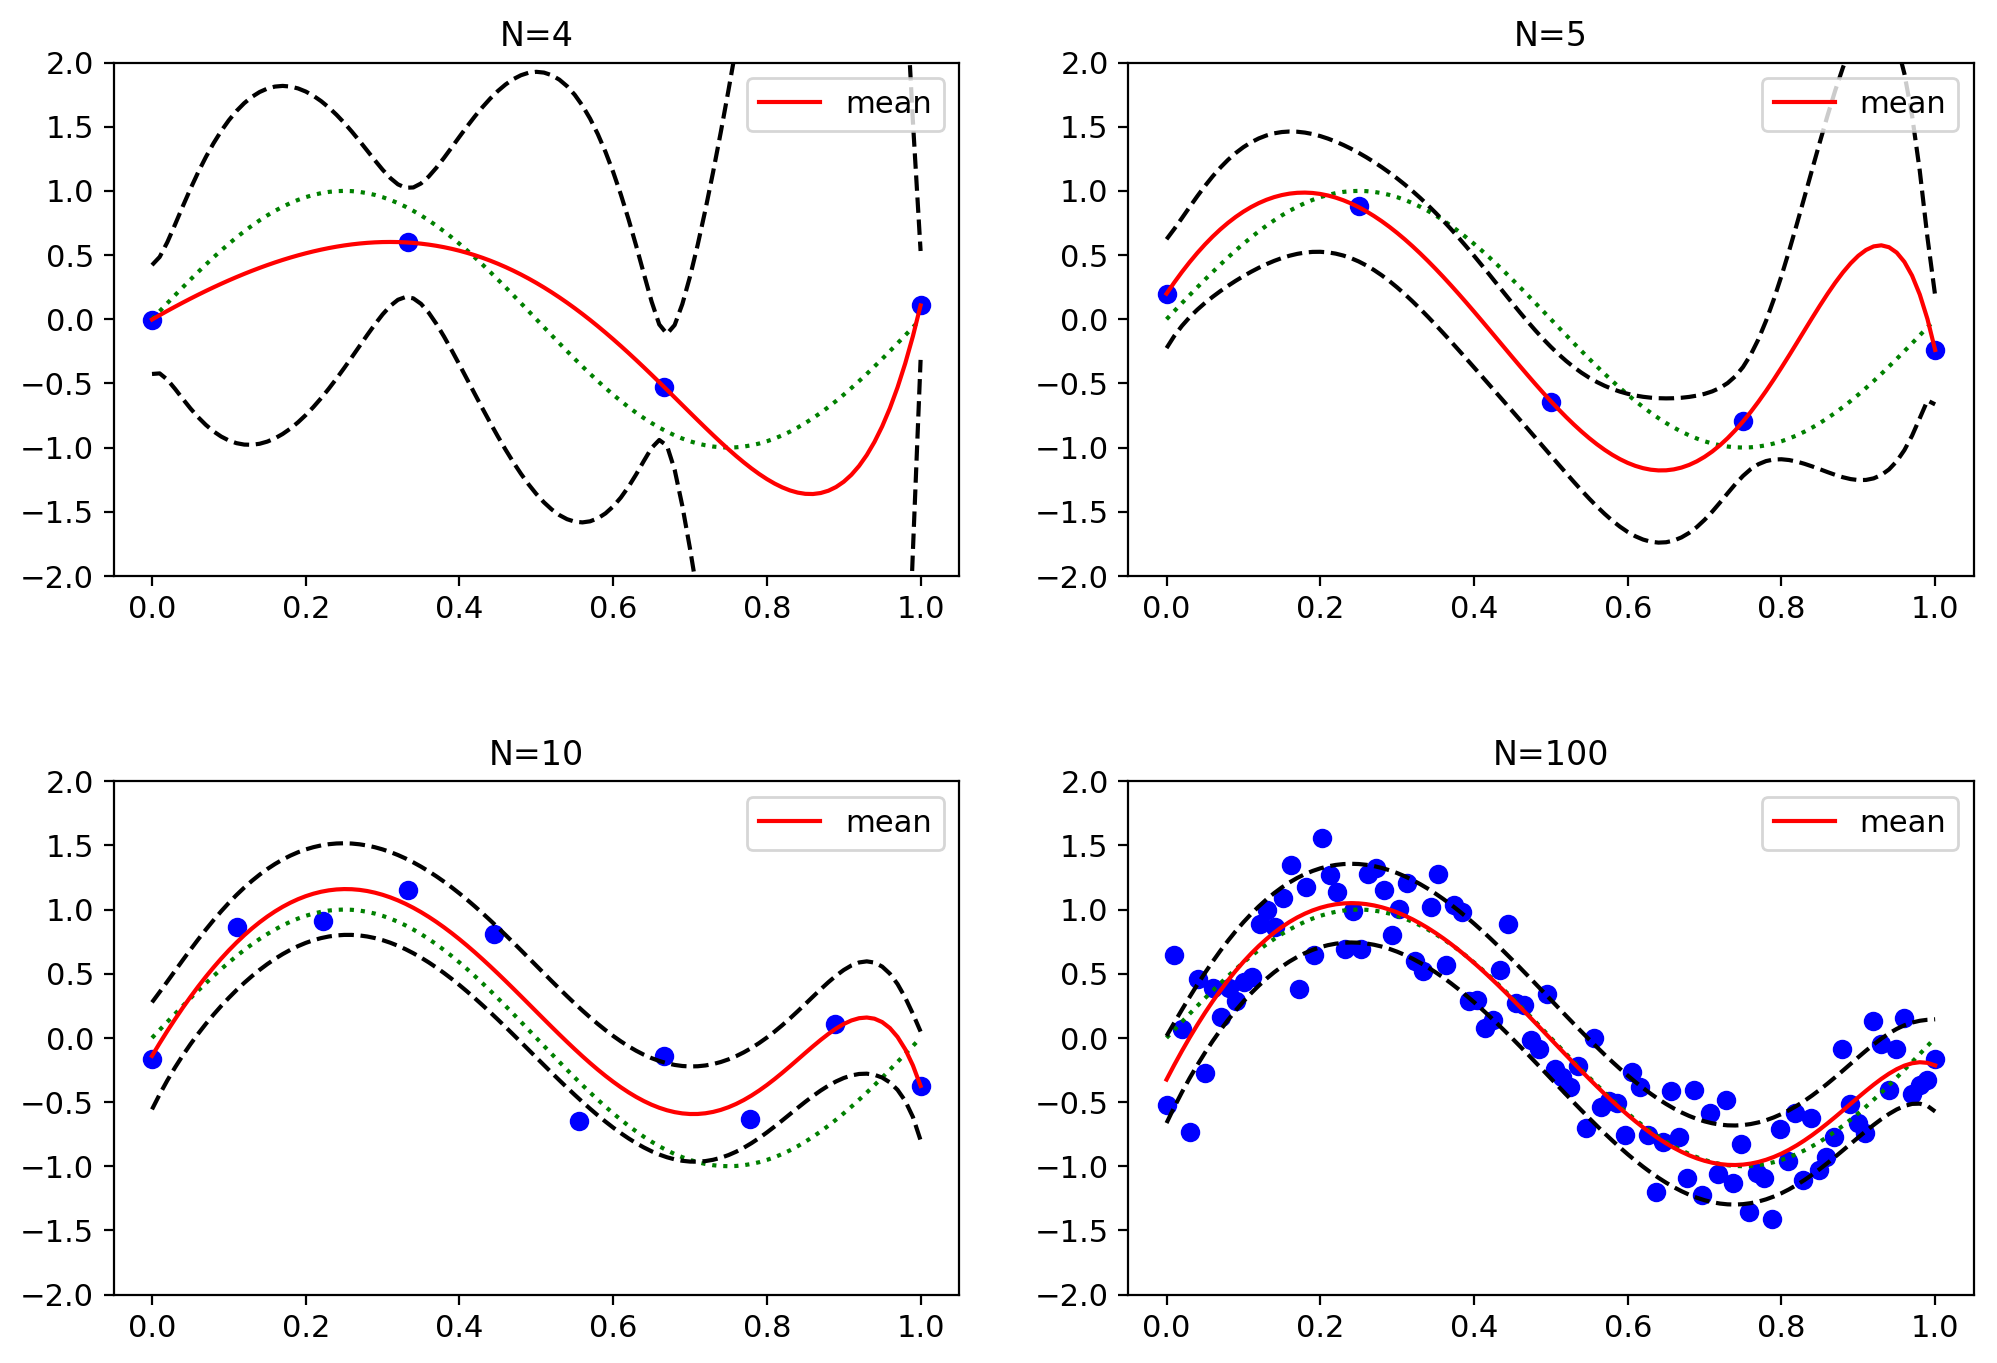

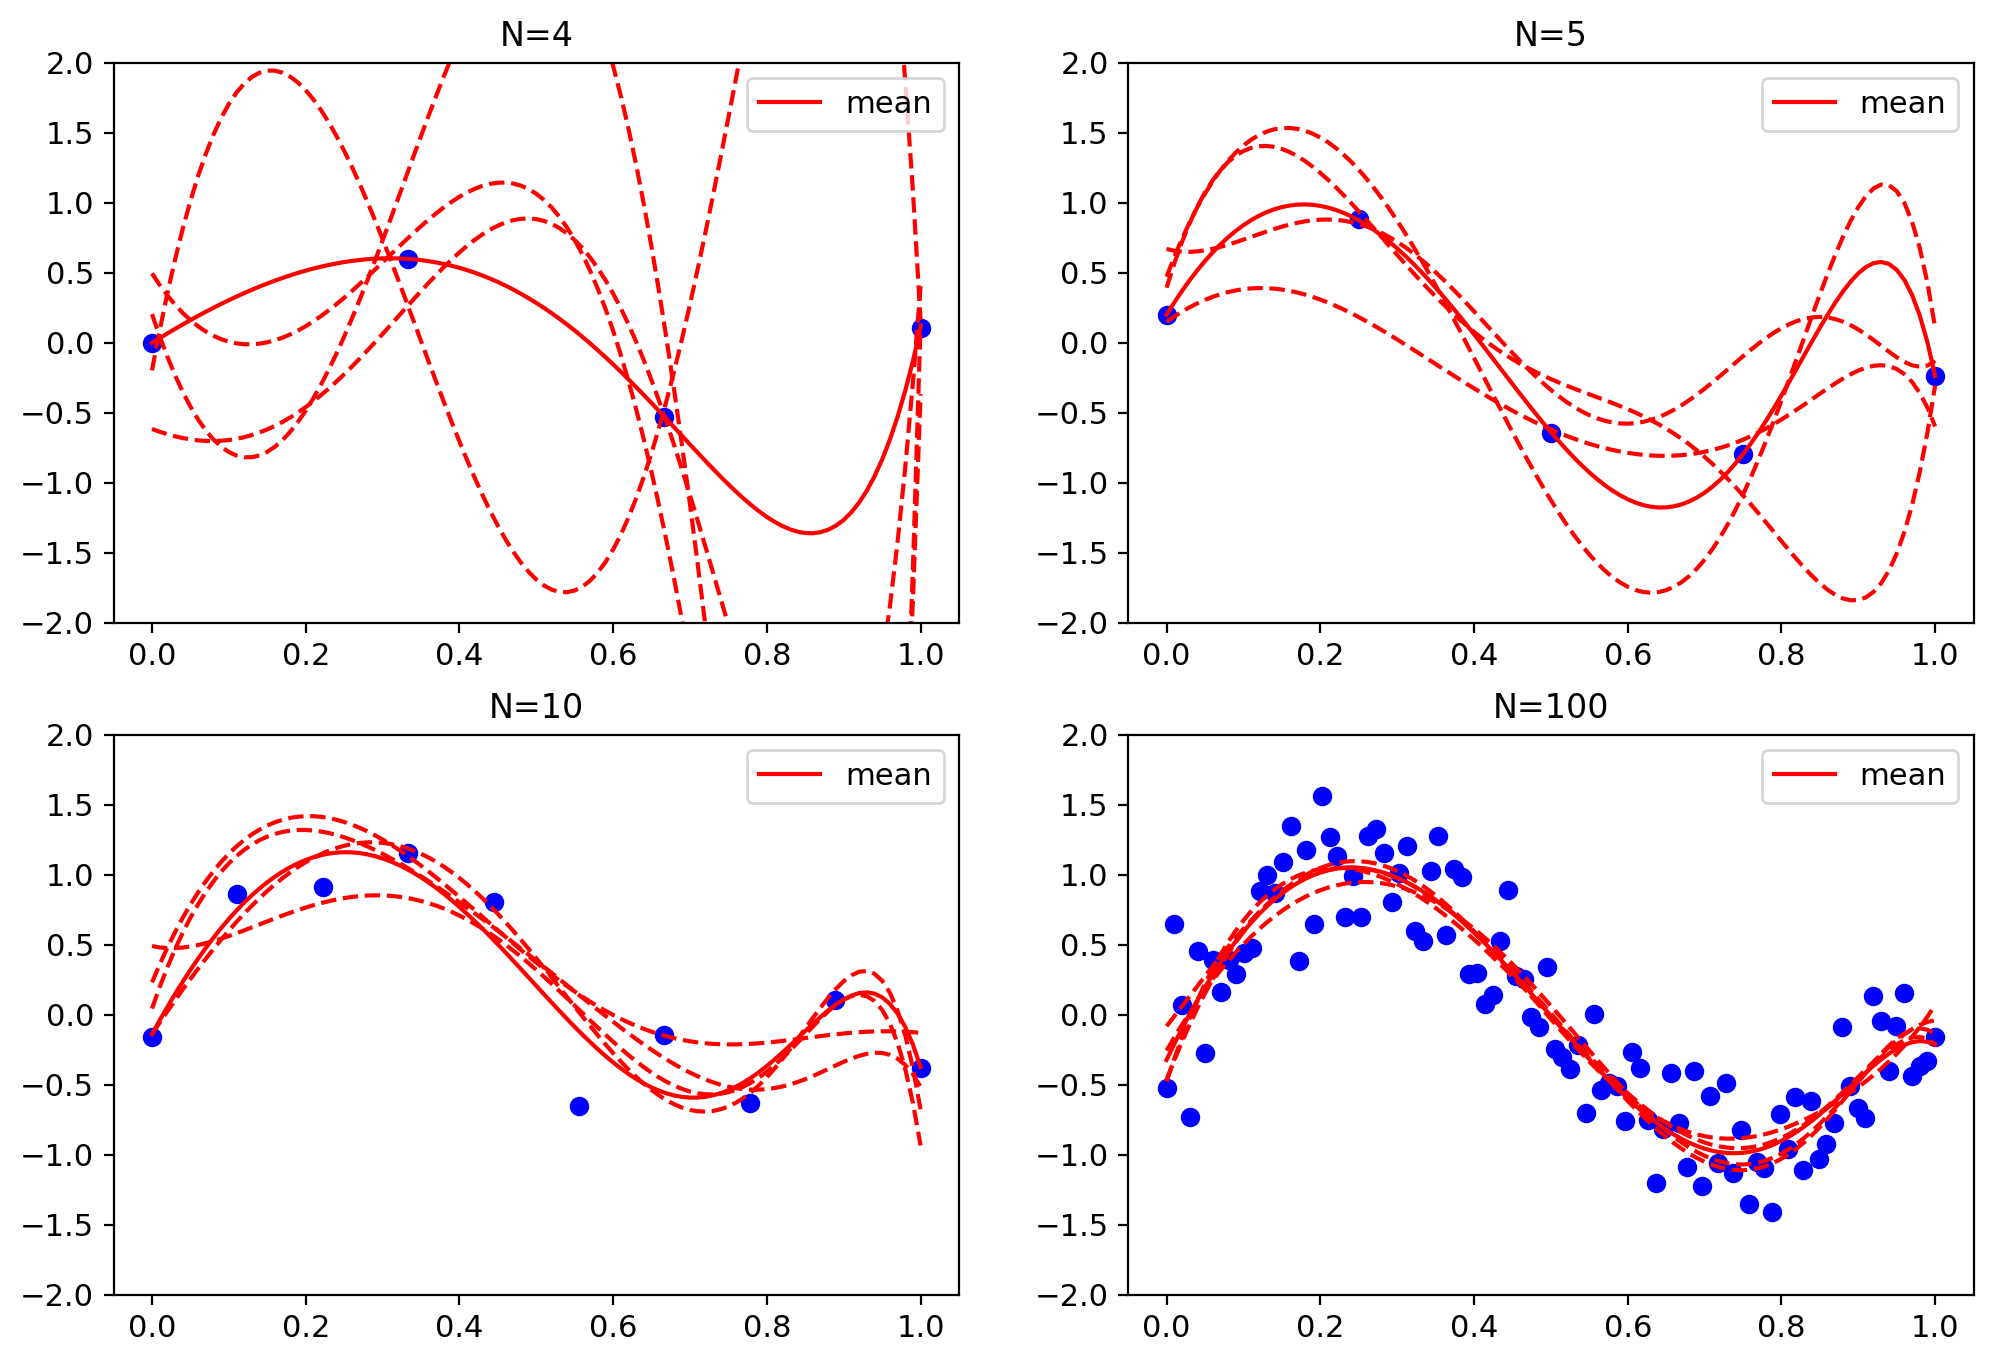

In [20]:
# Main
if __name__ == '__main__':
    df_ws = DataFrame()

    fig1 = plt.figure(figsize=(12,8))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    fig2 = plt.figure(figsize=(12,8))
    for c, num in enumerate([4,5,10,100]): # トレーニングセットのデータ数
        train_set = create_dataset(num)
        mean_fun, deviation_fun, mean, sigma = resolve(train_set, order)
        ws_samples = DataFrame(multivariate_normal(mean,sigma,4))

        subplot1 = fig1.add_subplot(2,2,c+1)
        subplot1.set_xlim(-0.05,1.05)
        subplot1.set_ylim(-2,2)
        subplot1.set_title("N=%d" % num)

        subplot2 = fig2.add_subplot(2,2,c+1)
        subplot2.set_xlim(-0.05,1.05)
        subplot2.set_ylim(-2,2)
        subplot2.set_title("N=%d" % num)

        # トレーニングセットを表示
        subplot1.scatter(train_set.x, train_set.y,
                         marker='o', color='blue', label=None)
        subplot2.scatter(train_set.x, train_set.y,
                         marker='o', color='blue', label=None)

        linex = np.arange(0,1.01,0.01)

        # 真の曲線を表示
        liney = np.sin(2*np.pi*linex)
        subplot1.plot(linex, liney, color='green',linestyle=':')

        # 平均と標準偏差の曲線を表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        subplot1.plot(linex, m, color='red', label='mean')
        subplot1.legend(loc=1)
        subplot1.plot(linex, m-d, color='black', linestyle='--')
        subplot1.plot(linex, m+d, color='black', linestyle='--')

        # 多項式のサンプルを表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        liney = m
        subplot2.plot(linex, liney, color='red', label="mean")
        subplot2.legend(loc=1)

        def f(x, ws):
            y = 0
            for i, w in enumerate(ws):
                y += w * (x ** i)
            return y

        for index, ws in ws_samples.iterrows():
            liney = f(linex, ws)
            subplot2.plot(linex, liney, color='red', linestyle='--')

#     fig1.show()
#     fig2.show()
    plt.show()